In [1]:
%matplotlib inline

import os
import sys
import copy
import random
import tqdm.notebook as tq

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms.functional as TF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =',device)

device = cuda:0


# Load Data

In [2]:
# Files are in 'input' directory
img_dir = 'input/train_images_256'
mask_dir = 'input/train_masks_256'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(img_dir) for name in files]

msk_files = [os.path.join(path, name) for path, subdirs, files in os.walk(mask_dir) for name in files]

print('Image files: ', len(img_files))
print('First 5 file names:', img_files[0:5])
print()
print('Mask files: ', len(msk_files))
print('First 5 file names:', msk_files[0:5])

Image files:  790
First 5 file names: ['input/train_images_256/041869.000023.tif', 'input/train_images_256/041874.000046.tif', 'input/train_images_256/045590.000176.tif', 'input/train_images_256/045594.000047.tif', 'input/train_images_256/041874.000063.tif']

Mask files:  790
First 5 file names: ['input/train_masks_256/041869.000023.tif', 'input/train_masks_256/041874.000046.tif', 'input/train_masks_256/045590.000176.tif', 'input/train_masks_256/045594.000047.tif', 'input/train_masks_256/041874.000063.tif']


In [3]:
def image_properties(img):
    '''
    Print image file properties
    '''
    print('image type:', type(img))
    print('image mode:', img.mode)
    print('image info:', img.info)
    array = np.array(img)
    print('image shape:', array.shape)
    print('min:', array.min(),'std:', array.std(),'mean:', array.mean(), 'max:',  array.max())
    print('array:', array)

def preview(images):
    '''
    Preview images stacked horizontally
    '''
    fig, axs = plt.subplots(1, len(images), figsize=(10,10))
    for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

image:
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
image mode: I;16
image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}
image shape: (256, 256)
min: 8499 std: 4967.71548363524 mean: 26219.83383178711 max: 54887
array: [[25850 39660 35057 ... 27621 21955 22309]
 [32578 35057 28329 ... 15227 19476 26204]
 [43201 31516 33640 ... 12748 19476 22663]
 ...
 [31870 24788 26558 ... 29391 21247 25142]
 [25142 23017 25496 ... 26204 24434 24079]
 [31516 26204 24079 ... 15581 27266 27621]]

mask: 
image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
image mode: L
image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}
image shape: (256, 256)
min: 0 std: 0.10272401750228878 mean: 0.00823974609375 max: 2
array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


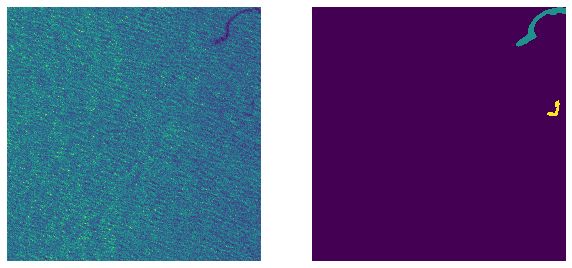

In [4]:
# Preview image and mask

print('image:')
img = Image.open(img_files[0])
image_properties(img)
# I;16 mode = 16-bit unsigned integer pixels
print()

print('mask: ')
msk = Image.open(msk_files[0])
image_properties(msk)
# L mode = 8-bit pixels, black and white
preview((img, msk))

## Image Transform Fuctions

(256, 256)
(256, 256)
(7, 256, 256)
(256, 256)


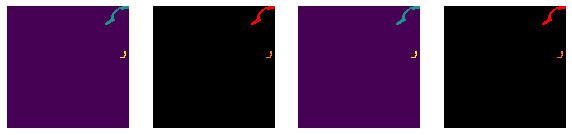

In [6]:
# We need to convert L to P(palette mode) to view the mask images nicely 
def palette():
    '''
    Returns palette (used in 'P' mode of image representation)
    '''
    colors_dict = {
        0: [0, 0, 0],       # 0 = background: black
        1: [255, 0, 0],     # 1 = seep class 1: red
        2: [255, 127, 0],   # 2: orange 
        3: [255, 255, 0],   # 3: yellow
        4: [0, 255, 0],     # 4: green
        5: [0, 0, 255],     # 5: blue
        6: [46, 43, 95],    # 6: dark blue
        7: [139, 0, 255],   # 7: purple
        }
    palette = []
    for i in np.arange(256):
        if i in colors_dict:
            palette.extend(colors_dict[i])
        else:
            palette.extend([0, 0, 0])
    return palette

def mask2p(msk):
    """
    Converts mask to P-mode image
    """
    msk=msk.convert('P')
    msk.putpalette(palette())
    return msk

def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (C,H,W) where the 0 dim is a C-one-hot encoding vector
    Where K - number of classes
    """
    classes = [1,2,3,4,5,6,7] # Classes in the dataset
    mask = np.asanyarray(mask)
        
    _mask = [mask == i for i in classes]
    mask = np.array(_mask).astype(np.uint8)
      
    #mask = np.where(mask == 0, 0, 1).astype(np.uint8) # for 1 channel only
    return mask

def onehot2mask(onehot):
    """
    Converts onehot representation (C, H, W) to mask representation (H,W)
    """
    zeros = np.zeros_like(onehot[0,:,:])
    zeros = np.expand_dims(zeros, axis=0)
    onehot = np.concatenate((zeros, onehot), axis=0)    
    array = np.argmax(onehot, axis=0).astype(np.uint8)
    
    #array = onehot.astype(np.uint8) # for 1 channel

    return Image.fromarray(array, 'L')

def onehot2p(onehot):
    """
    Converts onehot representation (C, H, W) to P image mask representation (H,W)
    """
    mask = onehot2mask(onehot)
    maskp = mask2p(mask)
    return maskp

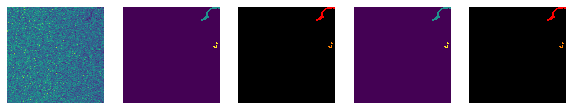

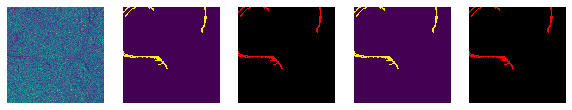

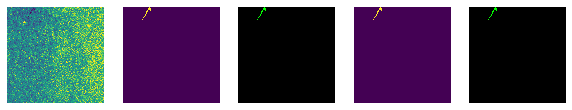

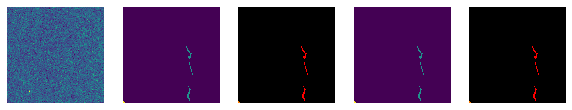

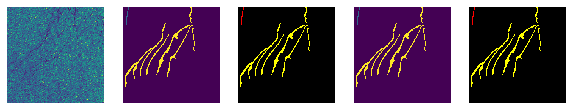

In [7]:
# Check that all conversions work fine, preview some images
n_preview = 5
for i in range(n_preview):
    img = img_files[i]
    msk = msk_files[i]
    img = Image.open(img)
    msk = Image.open(msk)
    mskp = mask2p(msk)
    onehot = mask2onehot(msk)
    #preview((msk, mskp, onehot))
    
    invonehot = onehot2mask(onehot)
    invonehotp = onehot2p(onehot)
    preview((img, msk, mskp, invonehot, invonehotp))

## Train/Test Split
Not huge amount of data so need to leave at least 20% for val

In [8]:
from sklearn.model_selection import train_test_split

imgs_train, imgs_val, msks_train, msks_val = \
    train_test_split(img_files, msk_files, test_size=0.2, shuffle=True, random_state=42)
print(len(imgs_train), len(imgs_val))

632 158


In [9]:
def class_distribution(filenames, show=False):
    all = []
    for msk in filenames:
        msk = Image.open(msk)
        array = np.array(msk)
        all.append(array)
    all = np.array(all)
    all.flatten()
    counts = np.unique(all, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])
    if show:
        plt.bar(counts[0][1:], counts[1][1:]) # dont show class 0 - background
        plt.show()

classes: [0 1 2 3 4 5 6 7]
counts: [40675049   420920    54244    18617    35771   121260    86464     6427]


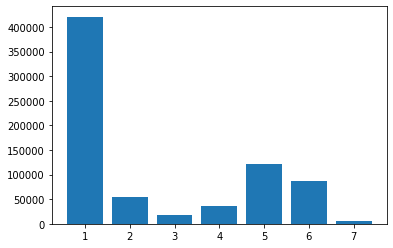

classes: [0 1 2 3 4 5 6 7]
counts: [40675049   420920    54244    18617    35771   121260    86464     6427]


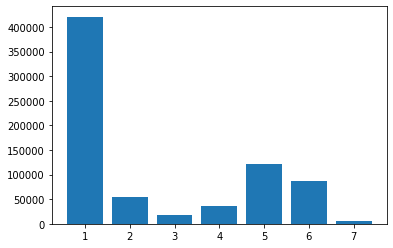

classes: [0 1 2 3 4 5 6 7]
counts: [10163439   104415    10514     3872     7186    33931    29765     1566]


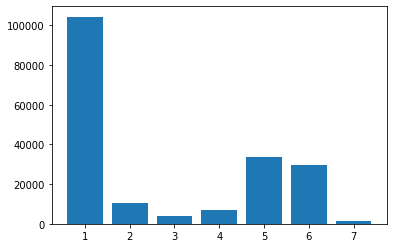

In [10]:
class_distribution(msks_train, show=True)
# The problem is quite imbalanced with class 1 - 65 times more represented then class 7

class_distribution(msks_train, show=True)
class_distribution(msks_val, show=True)
# Val set distribution is slightly different from train. Test split - possibly needs improvement, but looks fine.

## Make Dataset

### Augmentation
The obtained images are most definitly satelite images (so no difference in distance/zoom). The physics involved includes waves on the sea (needs some medium speed wind). The image contrast is mainly due to different density and surface tension on the oil-air and gas-air interface vs normal water-air interface. Due to different surface tension the shape of waves changes and the contrast arize. Becase the images are from satelite and waves are important, I don't think it's a good idea to zoom in and out for image augmentation (will check later if have time). Only rotation and horizontal flip was used for augmentation. Other possibility is to pad images and use random crop, but should not make much difference because fully convolutional CNNs should be invariant to feature location.

Normal way augmentation using transforms is possible simultaneously for image and mask (if same seed is used). Here I used different approach, obtaining the parameters directly and implementing them simultaneously to image and mask.

In [11]:
# Images need to be normalized, let's find normalization parameters:
lst = []
for image in imgs_train:
    image = Image.open(image)
    array = np.array(image)
    lst.append(array)
MU = np.mean(lst)
STD = np.std(lst)    
print('mean:', MU, 'std:', STD, 'min:', np.min(lst), 'max:', np.max(lst))

mean: 28974.71406021601 std: 10697.437589236108 min: 0 max: 65535


In [12]:
def normalize(im):
    """
    Normalize numpy array using MU and STD
    """
    im = np.array(im)
    im = (im - MU)/STD
    return im

def inv_normalize(im):
    """
    Inverse normalize numpy array using MU and STD
    Returns: Image
    """
    #im = im.numpy()
    im = np.squeeze(im)
    im = im * STD + MU
    im = im.astype('uint16')
    im = Image.fromarray(im, 'I;16')
    return im

In [16]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, augment):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.augment = augment

    def transform(self, image, mask, augment):
        if augment:
            # Random rotate
            rotate = transforms.RandomRotation(180)
            angle = rotate.get_params(rotate.degrees)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

        image = normalize(image)
        image = TF.to_tensor(image)
        
        mask = mask2onehot(mask)
        mask = torch.tensor(mask, dtype=torch.uint8)
        mask = torch.unsqueeze(mask,0)
        
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask, augment=self.augment)
        return x, y

    def __len__(self):
        return len(self.image_paths)

# Instantiate Datasets
train_dataset = MyDataset(imgs_train, msks_train, augment=True)
val_dataset = MyDataset(imgs_val, msks_val, augment=False)

In [17]:
# Check Dataloaders
iterator_train = iter(train_dataset)
iterator_val = iter(val_dataset)

image:
<class 'torch.Tensor'> torch.Size([1, 256, 256])
-2.7085658428492 2.589805802434443 1.0910915247326844 -0.2717585813007296
image shape: (256, 256)
mask:
<class 'torch.Tensor'> torch.Size([1, 7, 256, 256])
onehot shape: (1, 7, 256, 256)
onehot squeeze: (7, 256, 256)
0 1 0.024565168276311056 0.0006038120814732143


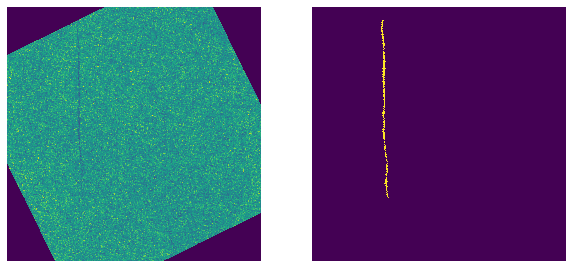

In [19]:
# Preview from dataloader
image, onehot = next(iterator_train)

print('image:')
print(type(image), image.shape)

image = image.numpy()
print(image.min(), image.max(), image.std(), image.mean())
image = np.squeeze(image)
print('image shape:', image.shape)
image = inv_normalize(image)

print('mask:')
print(type(onehot), onehot.shape)
onehot = onehot.numpy()
print('onehot shape:', onehot.shape)
onehot = np.squeeze(onehot)
print('onehot squeeze:', onehot.shape)

print(onehot.min(), onehot.max(), onehot.std(), onehot.mean())
mask = onehot2mask(onehot)
preview((image, mask))

In [20]:
# Create Dataloaders
BATCH_SIZE = 16
dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('n_batches_train:', len(dataloader_train), 'n_batches_val:', len(dataloader_val))

n_batches_train: 40 n_batches_val: 10


## Model
UNet model used for trainig

In [22]:
from segmentation_models import UNet
model = UNet(7, 1)
model=model.to(device)
summary(model, input_size=(1, 256, 256)) # input size required to do the forward pass throught the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

## Loss

Good short description of segmentation losses:
https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5

Good implementation (with extra unused parameters - so removed here)
https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

- BCELoss takes into account false positives (FP) - so not a good metric per se for segmentation tasks with a lot of background (as here)
- Dice (doesn't take into accout FP) is a good metric for imbalanced datasets
- Combo loss DiceBCELoss (Dice + weighted BCE) with small bce weight is a good way to go forward - exploits good convergence from BCE and concentrates on Dice
- Even better way is to use Focal Tversky loss - which helps to make attention on small segmentation masks and helps fighting imbalance problem



- Here I used DiceBCELoss and FocalTversky.
- I used BCELoss and DiceLoss as an additional metric to monitor training - these simple metrics help to understand what's going on in trainig.

In [23]:
from segmentation_loss import BCELoss, DiceLoss, DiceBCELoss, FocalTverskyLoss


## Train Function

In [43]:
def train(model, optimizer, scheduler, loss_fn, num_epochs=1, evaluate=1):
    
    # init Loss functions used to track performance
    dice_loss = DiceLoss()
    bce_loss = BCELoss() # only bce for 
    
    #Check device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device =',device)
    model=model.to(device)

    # Instantiate Tensorboard SummaryWriter
    writer = SummaryWriter()    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    #Initialize some variables
    best_loss = 1e10
    lr = 0 #required so that learning rate prints first time   
    
    total_train_samples = 0
    total_test_samples = 0   
    
    # Iterate over epochs
    for epoch in tq.tqdm(range(num_epochs)):

        # print learning rate if it was changed in this epoch
        # otherwize don't print it
        if lr != optimizer.param_groups[0]['lr']:
            lr = optimizer.param_groups[0]['lr']
            print('learning rate =', lr)
        
        #Train      
        model.train()
        torch.set_grad_enabled(True)
       
        for imgs, msks in dataloader_train:
            
            imgs = imgs.to(device, dtype=torch.float32)    
            msks = msks.to(device, dtype=torch.float32)
            
            batch_size = imgs.size(0)
            total_train_samples += batch_size

            optimizer.zero_grad()
            msks_pred = model(imgs)            
  
            loss = loss_fn(msks_pred, msks)
            
            writer.add_scalar('train_loss', loss, total_train_samples)
            
            loss.backward()            
            optimizer.step()       
        
       
        #Eval        
        if epoch % evaluate == 0: # evaluate results for epochs # 0 and all multiples of evaluate
            
            model.eval()
            torch.set_grad_enabled(False)
            
            epoch_bce_loss = 0
            epoch_dice_loss = 0           
            epoch_loss = 0            
            
            for imgs, msks in dataloader_val:
                
                imgs = imgs.to(device, dtype=torch.float32)
                msks = msks.to(device, dtype=torch.float32)
                
                batch_size = imgs.size(0)
                total_test_samples+=batch_size

                msks_pred = model(imgs)             
                loss = loss_fn(msks_pred, msks)
                
                writer.add_scalar('val_loss', loss, total_test_samples)                 
                
                epoch_dice_loss += dice_loss(msks_pred, msks)
                epoch_bce_loss += bce_loss(msks_pred, msks)
                epoch_loss += loss
            
            #Save best model
            save = '' # will print if model saved
            if epoch_loss < best_loss:
                save = 'model saved' # will print if model saved
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'current_best_model_state_dict.pth')
                
            print('epoch:', epoch,
                  'bce:', round(epoch_bce_loss.item(), 3),
                  'dice:', round(epoch_dice_loss.item(), 3),
                  'loss:', round(epoch_loss.item(), 3),  
                  save)
       
        #Step for learning rate scheduler
        scheduler.step()
    
    # Close SummaryWriter
    writer.close()
    
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

## Initialize Model Weights

- Model weights were initiated according to UNet publication

In [30]:
# https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/24
# https://pytorch.org/docs/stable/nn.init.html
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

model=model.to(device)

model.apply(weights_init)
#model.load_state_dict(torch.load('current_best_model_state_dict.pth', map_location=torch.device('cpu')))
print()

## Train

In [46]:
%%time

#%load_ext tensorboard
# !rm -rf runs # clean any previous data from tensorboard
#%tensorboard --logdir runs --host=127.0.0.1

optimizer = optim.Adam(model.parameters(), lr=3e-5)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.33)

#loss = DiceLoss()
#loss = DiceBCELoss(bce_weight=0.01)
loss = FocalTverskyLoss(alpha = 0.7, beta = 0.3, gamma = 1.33)

model=train(model=model, optimizer=optimizer, scheduler=exp_lr_scheduler, loss_fn=loss,  num_epochs=60, evaluate=3)

device = cuda:0


learning rate = 3e-05
epoch: 0 bce: 0.684 dice: 6.01 loss: 4.367 model saved
epoch: 3 bce: 0.659 dice: 5.791 loss: 4.273 model saved
epoch: 6 bce: 0.749 dice: 5.978 loss: 4.398 
epoch: 9 bce: 0.721 dice: 5.898 loss: 4.349 
epoch: 12 bce: 0.724 dice: 5.937 loss: 4.433 
epoch: 15 bce: 0.738 dice: 5.956 loss: 4.216 model saved
epoch: 18 bce: 0.74 dice: 5.874 loss: 4.247 
epoch: 21 bce: 0.765 dice: 5.617 loss: 4.164 model saved
epoch: 24 bce: 0.782 dice: 5.678 loss: 4.192 
epoch: 27 bce: 0.838 dice: 5.871 loss: 4.117 model saved
epoch: 30 bce: 0.922 dice: 6.04 loss: 4.277 
epoch: 33 bce: 0.772 dice: 5.603 loss: 4.125 
epoch: 36 bce: 0.77 dice: 5.603 loss: 4.128 
epoch: 39 bce: 0.799 dice: 5.638 loss: 4.126 
epoch: 42 bce: 0.815 dice: 5.597 loss: 4.24 
epoch: 45 bce: 0.791 dice: 5.713 loss: 4.104 model saved
epoch: 48 bce: 0.841 dice: 5.656 loss: 4.027 model saved
learning rate = 9.9e-06
epoch: 51 bce: 0.84 dice: 5.614 loss: 4.02 model saved
epoch: 54 bce: 0.824 dice: 5.653 loss: 3.964 mode

In [35]:
#torch.save(model.state_dict(), 'model_state_dict.pth')

## Preview Results

In [47]:
def distr(msk):
    array = np.array(msk)
    counts = np.unique(array, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])

In [63]:
iter_val = iter(dataloader_val)

mask:
classes: [0 4]
counts: [63630  1906]
pred:
classes: [0]
counts: [65536]


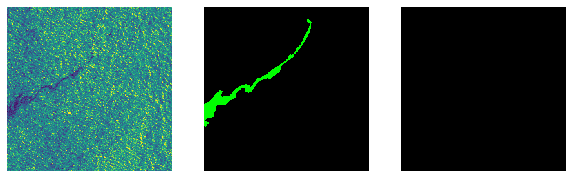

mask:
classes: [0 1]
counts: [64683   853]
pred:
classes: [0 1]
counts: [64808   728]


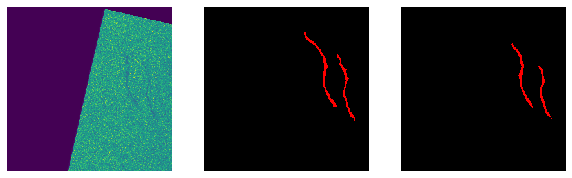

mask:
classes: [0 7]
counts: [65081   455]
pred:
classes: [0]
counts: [65536]


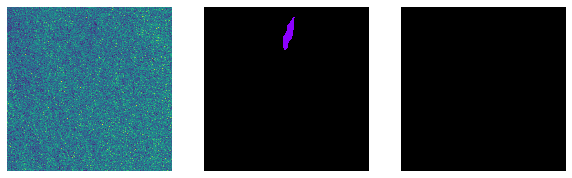

mask:
classes: [0 1 6]
counts: [58638  2623  4275]
pred:
classes: [0 1]
counts: [60175  5361]


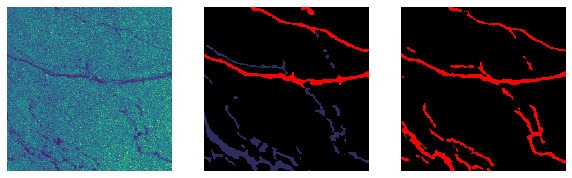

mask:
classes: [0 1 6]
counts: [63119   677  1740]
pred:
classes: [0 1]
counts: [63703  1833]


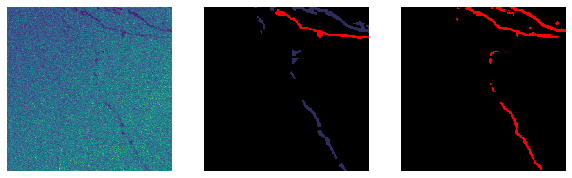

mask:
classes: [0 5]
counts: [65356   180]
pred:
classes: [0]
counts: [65536]


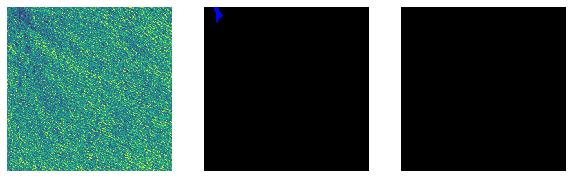

mask:
classes: [0 2]
counts: [65248   288]
pred:
classes: [0 1]
counts: [65329   207]


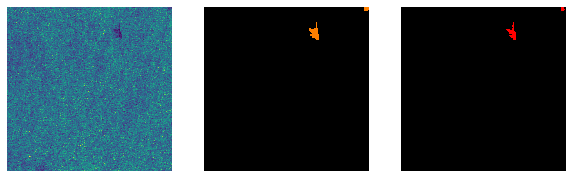

mask:
classes: [0 6]
counts: [65440    96]
pred:
classes: [0 1]
counts: [65476    60]


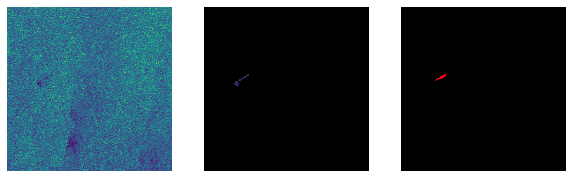

mask:
classes: [0 2 6 7]
counts: [65334    49   122    31]
pred:
classes: [0 1]
counts: [65430   106]


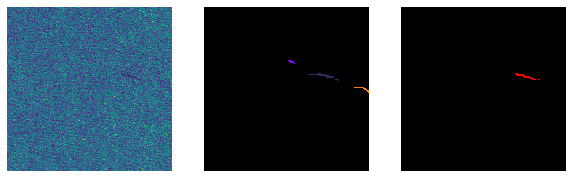

mask:
classes: [0 1]
counts: [65443    93]
pred:
classes: [0 1]
counts: [65518    18]


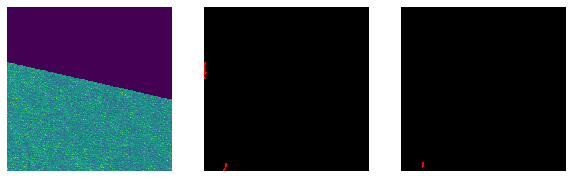

mask:
classes: [0 1 2]
counts: [63704  1830     2]
pred:
classes: [0 1]
counts: [64376  1160]


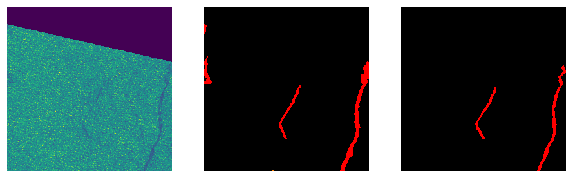

mask:
classes: [0 1]
counts: [61142  4394]
pred:
classes: [0 1]
counts: [63185  2351]


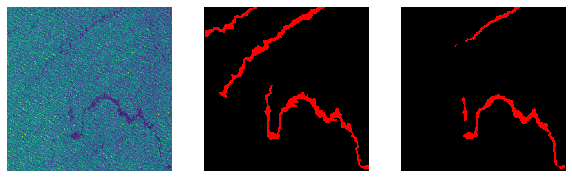

mask:
classes: [0 1 6 7]
counts: [65029   374   120    13]
pred:
classes: [0 1]
counts: [64964   572]


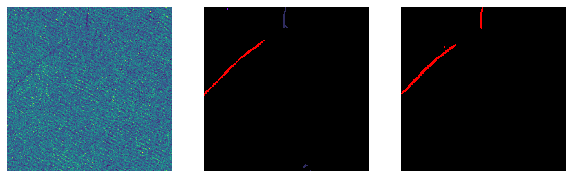

mask:
classes: [0 1]
counts: [64889   647]
pred:
classes: [0 1]
counts: [65082   454]


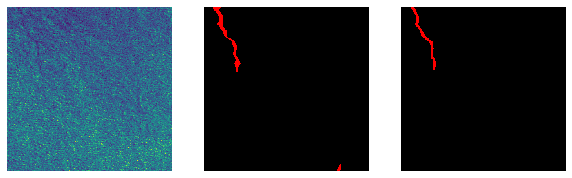

mask:
classes: [0 5]
counts: [60449  5087]
pred:
classes: [0 1]
counts: [64635   901]


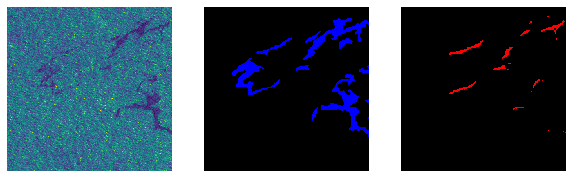

mask:
classes: [0 5]
counts: [65520    16]
pred:
classes: [0]
counts: [65536]


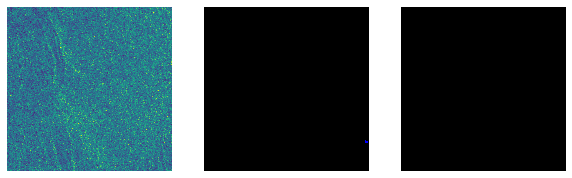

In [65]:
#Load current best model
model.load_state_dict(torch.load('current_best_model_state_dict.pth'))

# Preview images masks and predictions from validation set
images, masks = next(iter_val)

images = images.to(device)
model.eval()
torch.set_grad_enabled(False)
preds = model(images.float())

images = images.data.cpu().numpy()
masks = masks.data.cpu().numpy()
preds = preds.data.cpu().numpy()

#print(images.shape, masks.shape, preds.shape)

for i in range(images.shape[0]):
    image = images[i,:,:,:]
    mask = masks[i,:,:,:]
    pred = preds[i,:,:,:]

    
    image = np.squeeze(image)
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)   
    
    image = inv_normalize(image)       
        
    mask = onehot2mask(mask)
    print('mask:')
    distr(mask)
    
    pred = np.where(pred>0.5,1,0)
    pred = onehot2mask(pred)
    print('pred:')
    distr(pred)

    preview((image, mask2p(mask), mask2p(pred)))

## Way forward
- Train further. I trained the model for ~ 200 epochs and it still improves (both train and val), but no time anymore now
- There is a clear problem with classes imbalanced - only dominating class 1 was found. This might improve with training further, if not - one can try using weights (inversly proportional to classes frequency). 
- The other way around (easier to control) is to train separate models for each class and than blend them together.